# DATASET ANALYSIS 

##### IMPORTS

In [37]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from pathlib import Path

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.20.0-rc0


##### SEED AND DATASET PATH EXTRACTION

In [38]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [39]:
ROOT = Path.cwd()

# Full dataset
# dataset_dir = ROOT / "../data/FullPlantDataset/training"

# Sample dataset
dataset_dir = ROOT / "../data/FullPlantDataset/training_sample"

print(dataset_dir)

C:\Users\Giacomo Da Re\git\Challenges\Challenge1\notebooks\..\data\FullPlantDataset\training_sample


In [40]:
class_name = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

##### DATASET SIZE

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for training, validation, and test sets
train_data_gen = ImageDataGenerator()

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

Found 448 images belonging to 14 classes.


##### DATASET DISTRIBUTION

In [42]:
values = []
from pathlib import Path

for label in class_name: 
  plant_path = dataset_dir / label
  initial_count = 0
  for path in Path(plant_path).iterdir():
      if path.is_file():
        initial_count += 1
  values.append(initial_count)      

print(values)  

[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]


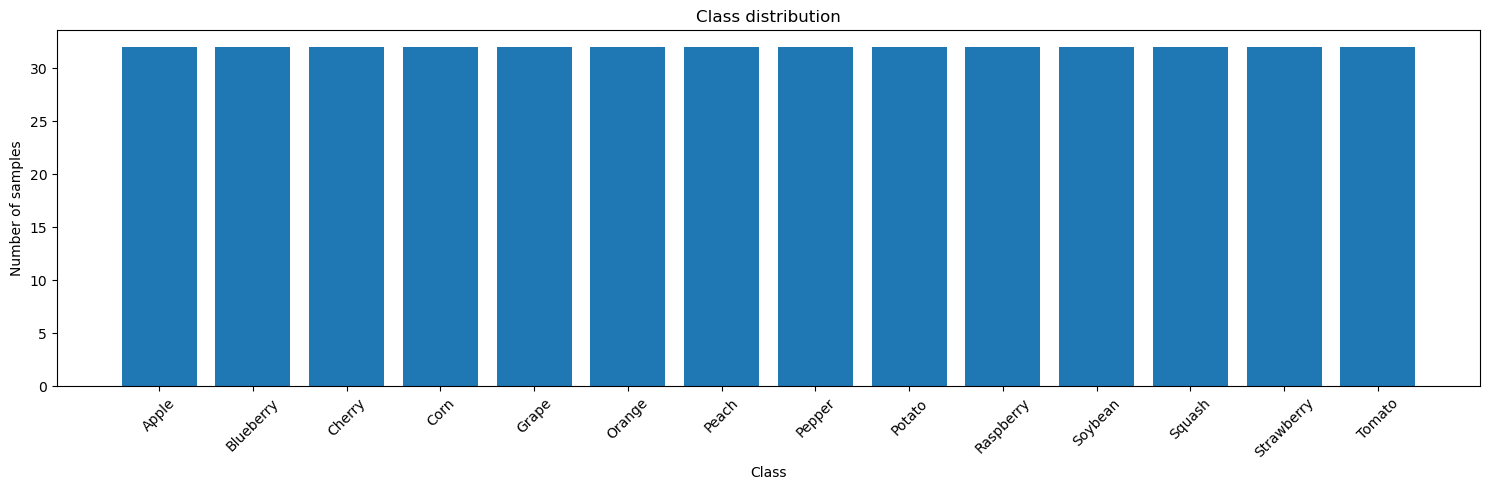

In [43]:
plt.figure(figsize=(15,5))
plt.bar(class_name, values)
plt.xticks(rotation=45); plt.xlabel("Class"); plt.ylabel("Number of samples"); plt.title("Class distribution"); plt.tight_layout()
plt.show()

In [44]:
# Relative percentage of the lables in the dataset
total = sum(values)
percent_by_label = {lbl: (v / total) * 100 if total else 0.0
                    for lbl, v in zip(class_name, values)}
print(percent_by_label)

{'Apple': 7.142857142857142, 'Blueberry': 7.142857142857142, 'Cherry': 7.142857142857142, 'Corn': 7.142857142857142, 'Grape': 7.142857142857142, 'Orange': 7.142857142857142, 'Peach': 7.142857142857142, 'Pepper': 7.142857142857142, 'Potato': 7.142857142857142, 'Raspberry': 7.142857142857142, 'Soybean': 7.142857142857142, 'Squash': 7.142857142857142, 'Strawberry': 7.142857142857142, 'Tomato': 7.142857142857142}


##### DATASET EXAMPLES

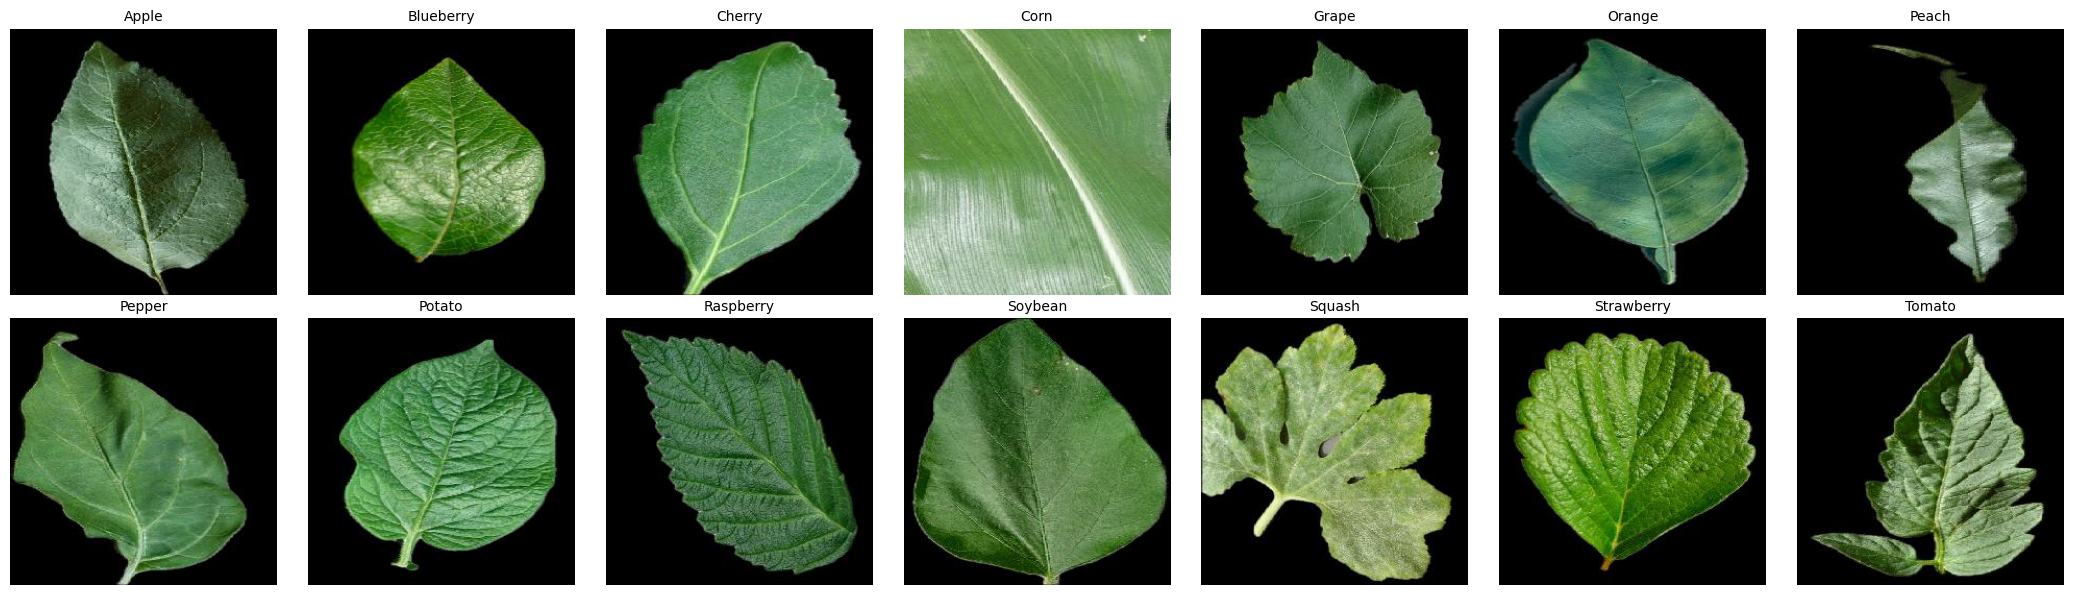

In [45]:
# Grid of examples from dataset
cols = 7
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
axes = np.atleast_1d(axes).ravel()  

labels = list(class_name)

for i, lab in enumerate(labels):
    ax = axes[i]
    plant_path = dataset_dir / lab
    first_file = sorted([p for p in plant_path.iterdir() if p.is_file()])[0]
    with Image.open(first_file) as im:
        ax.imshow(im)
    ax.set_title(lab, fontsize=10)
    ax.axis("off")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

##### DATASET AUGMENTATION EXAMPLES

Rotation: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': np.int64(38), 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': np.float64(0.9247240713084175), 'zy': np.float64(1.2704285838459497), 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

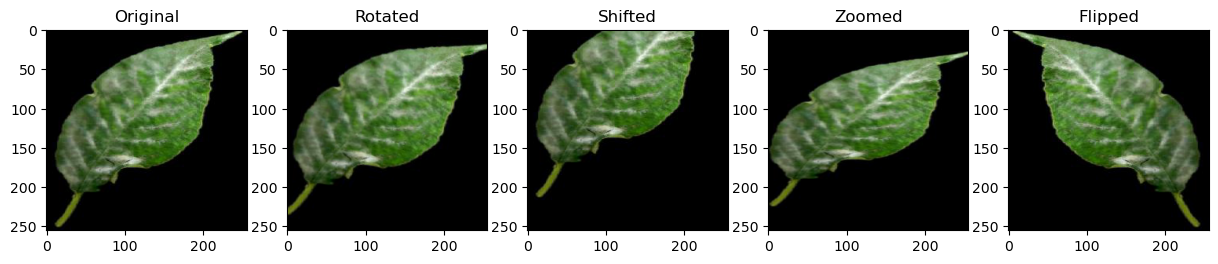

In [46]:
# Get sample image
image = next(train_gen)[0][7]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator(fill_mode='constant', cval=0.)
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t) 
zoomed = gen.apply_transform(image, zoom_t) 
flipped = gen.apply_transform(image, flip_t)  

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')